# Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV,ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, max_error
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Lectura

In [2]:
df = pd.read_csv('data\HISTORICO_SUERTES_cleaned.csv')

# Fase 1: Preparación y modelo base de regresión

**Objetivo:** preparar los datasets para cada objetivo (`TCH` y `%Sac.Caña`) eliminando posibles fugas de información, y entrenar modelos iniciales con ElasticNetCV.

---

#### 1) Eliminación de columnas de fecha
- Se removieron variables de tipo `datetime` del dataset, ya que no pueden ser utilizadas directamente en el modelo de regresión lineal.

---

#### 2) Prevención de data leakage
- **Para TCH**: eliminadas `TCHM`, `TonUltCorte`, `Ton.Azucar`, `TAH`, `TAHM`, `KATRHM`.  
- **Para %Sac.Caña**: eliminadas `TCH`, `TCHM`, `Ton.Azucar`, `TAH`, `TAHM`, `Rdto`, `%Sac.Muestreadora`, `%ATR`, `KATRHM`, `Brix`, `Pureza`.  
- Además, en ambos casos se removieron las variables objetivo de las features predictoras.

---

#### 3) División y estandarización
- Los datos fueron divididos en conjuntos de entrenamiento (80%) y prueba (20%).  
- Las variables predictoras fueron estandarizadas mediante **StandardScaler**, ajustando sobre entrenamiento y aplicando sobre prueba.

---

#### 4) Ajuste de modelo ElasticNetCV
- Se entrenaron dos modelos base con **ElasticNetCV** (uno para `TCH`, otro para `%Sac.Caña`).  
- ElasticNetCV ajusta automáticamente los hiperparámetros `alpha` y `l1_ratio` mediante validación cruzada.  
- Este paso establece los primeros modelos de referencia para evaluar posteriormente el desempeño en cada variable objetivo.



In [ ]:
# ---------- 1) Eliminar columnas de tipo fecha ----------
date_cols = df.select_dtypes(include=["datetime64", "datetime"]).columns
X_final = df.copy()

if not date_cols.empty:
    print(f"Eliminando {len(date_cols)} columnas de fecha: {date_cols.tolist()}")
    X_final = X_final.drop(columns=date_cols)
else:
    print("No se encontraron columnas de fecha para eliminar.")

# ---------- 2) Evitar fuga de información ----------
# Para TCH (Toneladas de Caña por Hectárea):
# - 'TonUltCorte': producción total = TCH * Área Neta (derivada directa de TCH).
# - 'Ton.Azucar': toneladas de azúcar = TCH * %Sac.Caña (derivada directa).
# - 'TAH' y 'TAHM': toneladas de azúcar/ha = TCH * %Sac.Caña (derivadas).
# - 'KATRHM': kilos de ATR/ha, también depende de TCH y %Sac.Caña.
# - 'TCHM': es una medición alternativa del mismo objetivo (TCH).
leaks_for_tch = [
    "TCHM", "TonUltCorte", "Ton.Azucar", "TAH", "TAHM", "KATRHM"
]
# Para %Sac.Caña (porcentaje de sacarosa en caña):
# - 'Rdto': rendimiento industrial, construido a partir de %Sac.Caña.
# - '%Sac.Muestreadora': estimación del mismo %Sac.Caña en laboratorio.
# - '%ATR': azúcares totales recuperables, depende de %Sac.Caña.
# - 'KATRHM': kilos ATR/ha, calculado con TCH y %Sac.Caña.
# - 'Ton.Azucar', 'TAH', 'TAHM': todas derivadas de TCH * %Sac.Caña.
# - 'TCH' y 'TCHM': no deben usarse porque ya son objetivos en otros modelos.
leaks_for_sac = [
    "TCH", "TCHM", "Ton.Azucar", "TAH", "TAHM",
    "Rdto", "%Sac.Muestreadora", "%ATR", "KATRHM", "Brix", "Pureza"
]

# Definir objetivos
y_tch = X_final["TCH"]
y_sac = X_final["%Sac.Caña"]

# Crear datasets sin leaks
X_tch = X_final.drop(columns=[c for c in leaks_for_tch if c in X_final.columns])
X_sac = X_final.drop(columns=[c for c in leaks_for_sac if c in X_final.columns])

# Quitar también las variables objetivo
X_tch = X_tch.drop(columns=["TCH", "%Sac.Caña"], errors="ignore")
X_sac = X_sac.drop(columns=["TCH", "%Sac.Caña"], errors="ignore")

# ---------- 3) Función para entrenar ElasticNetCV y guardar splits ----------
def train_elasticnet_cv(X, y, target_name="target"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Escalado
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)

    # ElasticNetCV
    enet_cv = ElasticNetCV(
        alphas=np.logspace(-3, 2, 50),
        l1_ratio=np.linspace(0.1, 0.9, 5),
        cv=5,
        random_state=42,
        max_iter=20000
    ).fit(Xtr, y_train)

    print(f"\nModelo entrenado para {target_name}")
    print(f"Alpha óptimo: {enet_cv.alpha_:.4f}")
    print(f"L1 ratio óptimo: {enet_cv.l1_ratio_:.2f}")

    return enet_cv, scaler, (Xtr, Xte, y_train, y_test)

# ---------- 4) Entrenar modelos y obtener splits ----------
enet_tch, scaler_tch, splits_tch = train_elasticnet_cv(X_tch, y_tch, "TCH")
enet_sac, scaler_sac, splits_sac = train_elasticnet_cv(X_sac, y_sac, "%Sac.Caña")


No se encontraron columnas de fecha para eliminar.

Modelo entrenado para TCH
Alpha óptimo: 0.0687
L1 ratio óptimo: 0.90

Modelo entrenado para %Sac.Caña
Alpha óptimo: 0.0032
L1 ratio óptimo: 0.90


# Fase 2: Análisis de Significancia y Regularización

En esta fase se buscó identificar las variables más relevantes en la predicción de **TCH** y **%Sac.Caña**, 
combinando dos enfoques:

1. **OLS (Ordinary Least Squares):** permite evaluar la **significancia estadística** de cada variable mediante los p-values.
2. **ElasticNetCV:** aplica regularización (L1 + L2), lo que reduce la multicolinealidad y encoge a cero muchos coeficientes, 
dejando solo las variables con mayor poder predictivo.

---

## Resultados OLS

- Para **TCH** (`R² = 0.376`), las variables más significativas incluyen:
  - **Semanas maduración** (coef. –1.09, p < 0.001) → cosechas más largas reducen TCH.
  - **Edad Última Cosecha** (coef. +2.49, p < 0.001) → mayor edad incrementa la productividad.
  - **%Fibra Caña** (coef. –2.45, p < 0.001) → altos contenidos de fibra reducen el rendimiento.
  - Variables climáticas como **Temp. Media / Máx / Mín Ciclo**, **Evaporación Ciclo** y **Radiación Solar Ciclo** también mostraron gran significancia.
  - Factores geográficos como **Zona_IP02** y **Zona_IP05** destacan con aportes positivos.

- Para **%Sac.Caña** (`R² = 0.524`), las variables significativas incluyen:
  - **%AR Jugo** (coef. –1.64, p < 0.001) → altos azúcares reductores disminuyen la sacarosa.
  - **%ME Tot** (coef. –0.19, p < 0.001) → mayor materia extraña reduce la pureza.
  - **Cod. T.Cultivo** (coef. –0.99, p < 0.001) → el tipo de cultivo tiene fuerte relación.
  - Variables climáticas (**Lluvias (2 Meses Ant.)**, **Temp. Media/Min/Máx Ciclo**) y de manejo (**Tipo Quema_VERDE**, **T.Corte_MECANIZADO**) resultaron altamente significativas.
  - Factores de área (**Área Neta**) y estado fenológico (**Cod.Estado #**) también mostraron asociación.

---

## Comparativa OLS vs ElasticNetCV

La siguiente tabla resume cómo ElasticNet actúa frente a las variables más significativas según OLS:

- **TCH**  
  - OLS detecta efectos grandes en **Semanas maduración**, **Edad Ult Cos**, clima y zonas.  
  - ElasticNet retuvo esas mismas variables clave, pero redujo la magnitud de los coeficientes y llevó muchos otros a cero.  
  - Se confirma que el modelo concentró la señal en clima, madurez y localización.

- **%Sac.Caña**  
  - OLS mostró gran significancia en **%AR Jugo**, **%ME Tot**, **Cod. T.Cultivo**, clima y manejo (tipo de quema y corte).  
  - ElasticNet mantuvo estas variables con peso no nulo, especialmente **%AR Jugo** y **%ME Tot**, pero eliminó mucho ruido estadístico.  
  - Esto refuerza la importancia de calidad tecnológica y condiciones de cosecha.

---

## Conclusión de la fase

- **OLS** permitió identificar qué variables son estadísticamente significativas para explicar la variabilidad de TCH y %Sac.Caña.
- **ElasticNetCV** confirmó y redujo el conjunto de predictores, conservando los más robustos frente a multicolinealidad.
- En resumen:
  - **TCH** depende principalmente de **edad de cosecha, semanas de maduración, clima y zona**.  
  - **%Sac.Caña** está más asociado a **características tecnológicas (azúcares, fibra, materia extraña) y manejo de cosecha**.


Resumen OLS (TCH): R² = 0.376
                   variable       coef   std_err          t        pvalue  \
8              Semanas mad.  -1.098776  0.082426 -13.330412  6.702946e-40   
45                Zona_IP02  17.569170  1.620898  10.839160  4.306098e-27   
44        Evaporacion Ciclo   0.031578  0.003085  10.236421  2.290303e-24   
10              %Fibra Caña  -2.454480  0.252045  -9.738261  3.174179e-22   
4              Edad Ult Cos   2.498988  0.280242   8.917248  6.466064e-19   
36           Temp Max Ciclo  -5.437775  0.740180  -7.346555  2.342263e-13   
35        Temp. Media Ciclo  -3.109428  0.426936  -7.283130  3.738658e-13   
47                Zona_IP05  10.922756  1.641787   6.652967  3.161275e-11   
40    Radiacion Solar Ciclo   0.409352  0.062482   6.551512  6.233645e-11   
37           Temp Min Ciclo  -7.248913  1.298658  -5.581850  2.497757e-08   
34          Temp. Media 0-3   3.781781  0.689200   5.487207  4.272620e-08   
41        Precipitacion 0_3   0.028827  0.0063

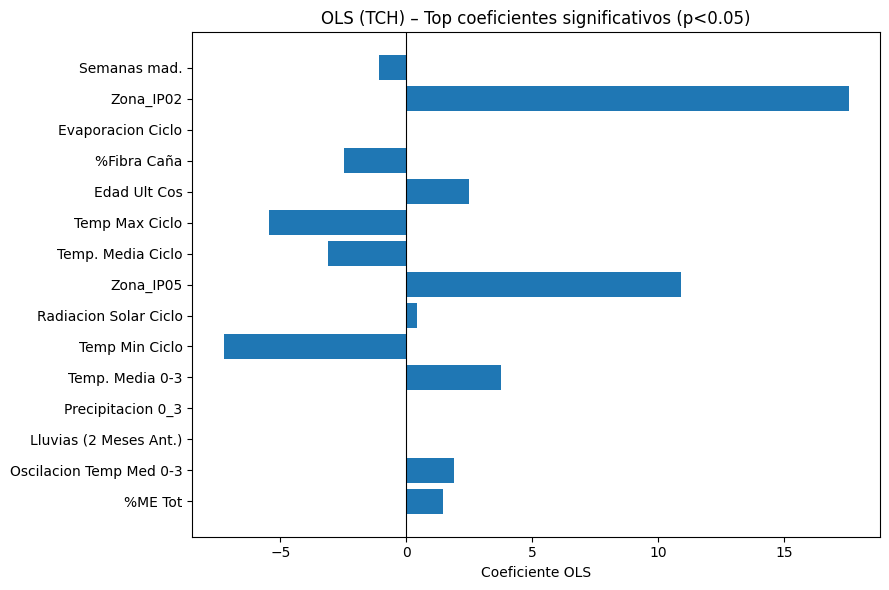

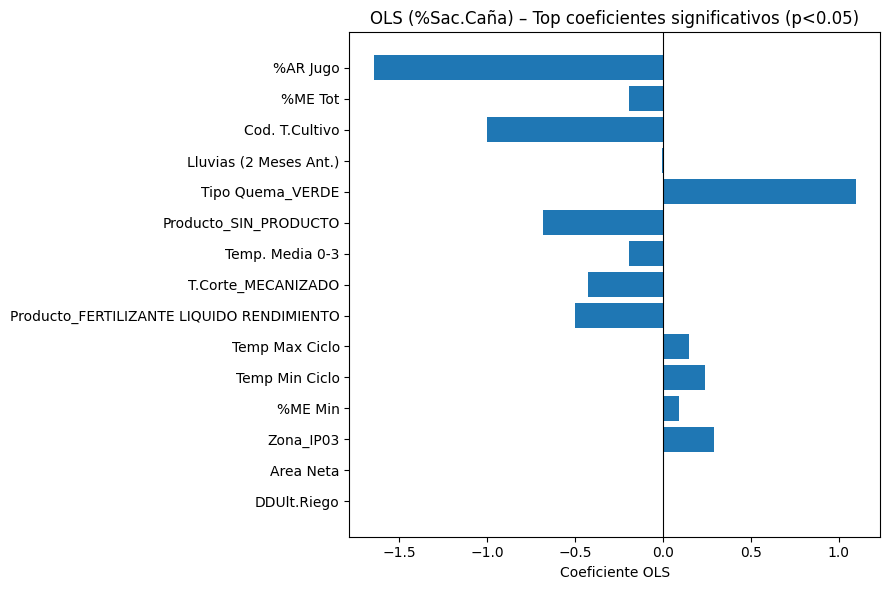

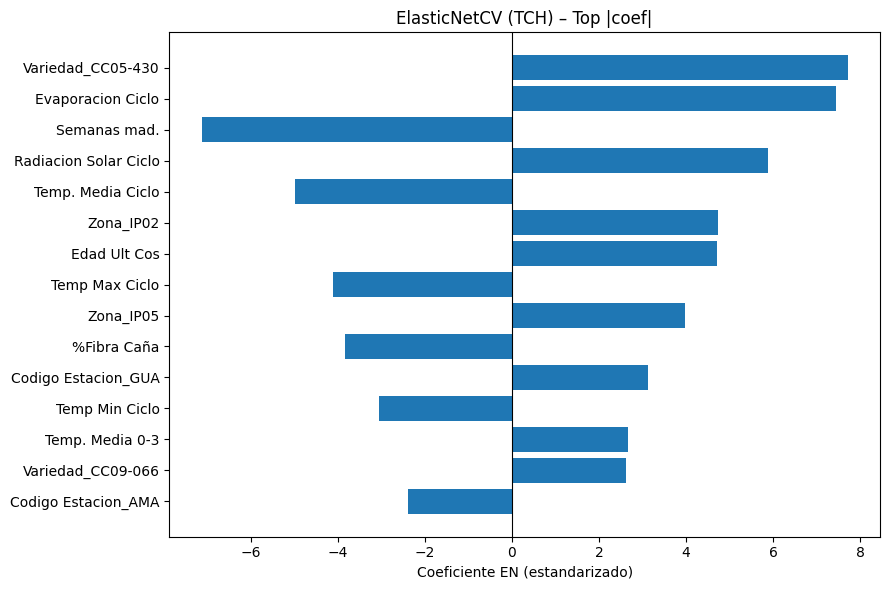

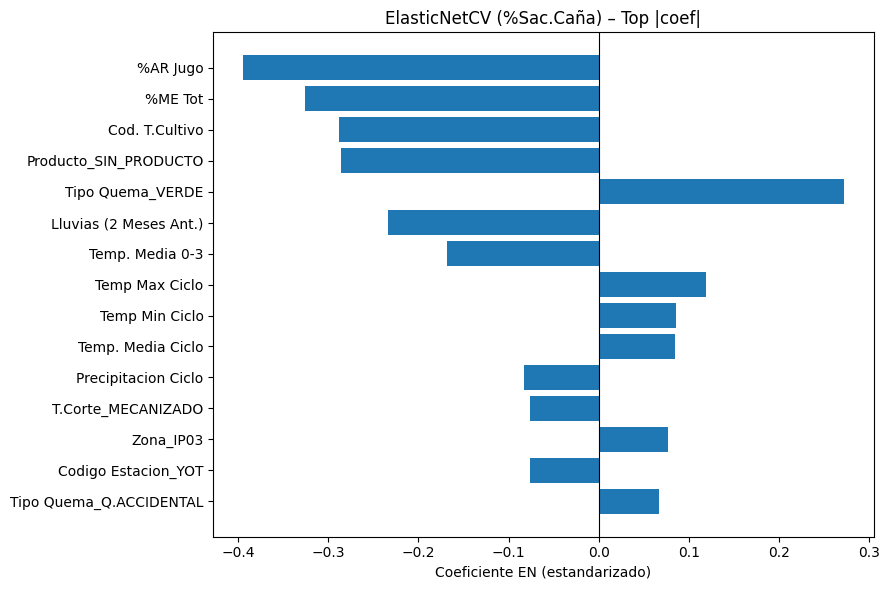


Comparativa OLS vs EN (TCH) – Top 20 OLS:
                          OLS_coef         OLS_p  EN_coef_std
Semanas mad.             -1.098776  6.702946e-40    -7.129004
Zona_IP02                17.569170  4.306098e-27     4.731922
Evaporacion Ciclo         0.031578  2.290303e-24     7.446218
%Fibra Caña              -2.454480  3.174179e-22    -3.826156
Edad Ult Cos              2.498988  6.466064e-19     4.708689
Temp Max Ciclo           -5.437775  2.342263e-13    -4.108494
Temp. Media Ciclo        -3.109428  3.738658e-13    -4.984079
Zona_IP05                10.922756  3.161275e-11     3.987210
Radiacion Solar Ciclo     0.409352  6.233645e-11     5.886311
Temp Min Ciclo           -7.248913  2.497757e-08    -3.043947
Temp. Media 0-3           3.781781  4.272620e-08     2.678549
Precipitacion 0_3         0.028827  6.468494e-06     1.728375
Lluvias (2 Meses Ant.)    0.028054  9.949431e-06     2.095232
Oscilacion Temp Med 0-3   1.917240  2.095729e-05     1.821046
%ME Tot                   1

In [4]:
# =====================================================
# Fase 2: Análisis de significancia (OLS) + Coeficientes ElasticNet
# =====================================================

# ---------- 0) Helper para resumir OLS ----------
def summarize_ols(model):
    summ = pd.DataFrame({
        "variable": model.params.index,
        "coef": model.params.values,
        "std_err": model.bse.values,
        "t": model.tvalues.values,
        "pvalue": model.pvalues.values,
    })
    ci = model.conf_int()
    summ["ci_low"] = ci[0].values
    summ["ci_high"] = ci[1].values
    return summ.sort_values("pvalue")

def plot_barh(series, title, xlabel="Coeficiente", top_n=15):
    s = series.copy().iloc[:top_n][::-1]  # top N, invertido
    plt.figure(figsize=(9, 6))
    plt.barh(s.index, s.values)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# ---------- 1) Reconstruir splits SIN escalar ----------
Xtr_tch_df, Xte_tch_df, ytr_tch, yte_tch = train_test_split(
    X_tch, y_tch, test_size=0.2, random_state=42
)
Xtr_sac_df, Xte_sac_df, ytr_sac, yte_sac = train_test_split(
    X_sac, y_sac, test_size=0.2, random_state=42
)

# ---------- 2) Verificar que todo es numérico ----------
for name, df in {"TCH": Xtr_tch_df, "%Sac.Caña": Xtr_sac_df}.items():
    non_numeric = df.select_dtypes(exclude=["number"]).columns.tolist()
    if non_numeric:
        print(f"[ALERTA] En {name} quedaron columnas no numéricas:", non_numeric)

# ---------- 3) OLS con nombres ----------
# TCH
Xtr_tch_sm = sm.add_constant(Xtr_tch_df.astype(float))
ols_tch = sm.OLS(ytr_tch.astype(float), Xtr_tch_sm).fit()
ols_tch_tbl = summarize_ols(ols_tch)

print("Resumen OLS (TCH): R² =", round(ols_tch.rsquared, 3))
print(ols_tch_tbl.head(15))

# %Sac.Caña
Xtr_sac_sm = sm.add_constant(Xtr_sac_df.astype(float))
ols_sac = sm.OLS(ytr_sac.astype(float), Xtr_sac_sm).fit()
ols_sac_tbl = summarize_ols(ols_sac)

print("\nResumen OLS (%Sac.Caña): R² =", round(ols_sac.rsquared, 3))
print(ols_sac_tbl.head(15))

# ---------- 4) Gráficos OLS (top coeficientes significativos p<0.05) ----------
ols_tch_sig = ols_tch_tbl[(ols_tch_tbl["variable"]!="const") & (ols_tch_tbl["pvalue"]<0.05)]
ols_sac_sig = ols_sac_tbl[(ols_sac_tbl["variable"]!="const") & (ols_sac_tbl["pvalue"]<0.05)]

ols_tch_sig = ols_tch_sig.sort_values("pvalue")
ols_sac_sig = ols_sac_sig.sort_values("pvalue")

plot_barh(ols_tch_sig.set_index("variable")["coef"], 
          "OLS (TCH) – Top coeficientes significativos (p<0.05)", 
          xlabel="Coeficiente OLS", top_n=15)

plot_barh(ols_sac_sig.set_index("variable")["coef"], 
          "OLS (%Sac.Caña) – Top coeficientes significativos (p<0.05)", 
          xlabel="Coeficiente OLS", top_n=15)

# ---------- 5) Coeficientes ElasticNetCV ----------
enet_tch_coefs = pd.Series(enet_tch.coef_, index=Xtr_tch_df.columns).sort_values(key=np.abs, ascending=False)
enet_sac_coefs = pd.Series(enet_sac.coef_, index=Xtr_sac_df.columns).sort_values(key=np.abs, ascending=False)

plot_barh(enet_tch_coefs, "ElasticNetCV (TCH) – Top |coef|", xlabel="Coeficiente EN (estandarizado)", top_n=15)
plot_barh(enet_sac_coefs, "ElasticNetCV (%Sac.Caña) – Top |coef|", xlabel="Coeficiente EN (estandarizado)", top_n=15)

# ---------- 6) Comparativa OLS vs ElasticNet ----------
top_vars_tch = ols_tch_sig["variable"].head(20).tolist()
top_vars_sac = ols_sac_sig["variable"].head(20).tolist()

compare_tch = pd.DataFrame({
    "OLS_coef": ols_tch_tbl.set_index("variable").loc[top_vars_tch, "coef"],
    "OLS_p": ols_tch_tbl.set_index("variable").loc[top_vars_tch, "pvalue"],
    "EN_coef_std": enet_tch_coefs.loc[[v for v in top_vars_tch if v in enet_tch_coefs.index]]
})
compare_sac = pd.DataFrame({
    "OLS_coef": ols_sac_tbl.set_index("variable").loc[top_vars_sac, "coef"],
    "OLS_p": ols_sac_tbl.set_index("variable").loc[top_vars_sac, "pvalue"],
    "EN_coef_std": enet_sac_coefs.loc[[v for v in top_vars_sac if v in enet_sac_coefs.index]]
})

print("\nComparativa OLS vs EN (TCH) – Top 20 OLS:")
print(compare_tch.head(20))
print("\nComparativa OLS vs EN (%Sac.Caña) – Top 20 OLS:")
print(compare_sac.head(20))


# Fase 3: Evaluación de supuestos de regresión

#### 1. Linealidad  
En los gráficos de **residuos vs valores ajustados**, los puntos se distribuyen en torno a la línea de referencia (cero), aunque no de manera perfectamente homogénea.  
- En **TCH**, se observa una nube amplia y con outliers notables, lo que indica que la linealidad se cumple de forma aproximada.  
- En **%Sac.Caña**, la relación es más ajustada y con menor dispersión.

---

#### 2. Independencia  
El estadístico **Durbin-Watson ≈ 2 en ambos modelos** confirma que no existe autocorrelación significativa entre los errores.  
✅ Supuesto de independencia cumplido.

---

#### 3. Homocedasticidad  
Los gráficos de residuos muestran varianzas relativamente constantes:  
- En **TCH**, se aprecia cierta heterocedasticidad en los valores extremos, asociada a outliers.  
- En **%Sac.Caña**, la dispersión es más uniforme.  
En general, el supuesto se cumple de forma aceptable.

---

#### 4. Normalidad de los errores  
- El **histograma de residuos** muestra distribuciones cercanas a la normalidad, aunque en **TCH** se evidencian colas pesadas y algunos valores extremos.  
- El **Q-Q plot** confirma que los residuos de TCH se desvían en los extremos, mientras que los de %Sac.Caña se ajustan mejor a la diagonal.  
➡️ La normalidad se cumple de forma aproximada, pero no estricta.

---

#### 5. Ausencia de multicolinealidad  
El **resumen OLS** reporta un **número de condición muy alto (>10^16)**, lo que evidencia multicolinealidad severa. Varias variables significativas presentan correlaciones elevadas entre sí, confirmando redundancia en los predictores.  

Por esta razón, se utilizó la **regularización con Elastic Net**, que combina L1 (selección de variables) y L2 (estabilización de coeficientes), reduciendo la varianza de las estimaciones y concentrando la señal en un subconjunto robusto de variables.

---

#### ✅ Conclusión  
Los modelos cumplen parcialmente los supuestos de regresión:  
- **Cumplen**: independencia, linealidad general y homocedasticidad aceptable.  
- **Limitaciones**: presencia de multicolinealidad y normalidad imperfecta de residuos, sobre todo en TCH.  

El uso de **Elastic Net** se justifica plenamente como estrategia para mitigar la multicolinealidad y aumentar la estabilidad de las predicciones.

### Variables más significativas para TCH:


C:\Users\Juan Jose\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Juan Jose\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Variable,Coef,p-value,Significativo
8,Semanas mad.,-55.358599,6.702946e-40,True
45,Zona_IP02,1.628155,4.306098e-27,True
44,Evaporacion Ciclo,2328.932909,2.290303e-24,True
10,%Fibra Caña,-6.473727,3.174179e-22,True
4,Edad Ult Cos,10.513322,6.466064e-19,True
36,Temp Max Ciclo,-4.065913,2.342263e-13,True
35,Temp. Media Ciclo,-12.896060,3.738658e-13,True
47,Zona_IP05,2.421664,3.161275e-11,True
40,Radiacion Solar Ciclo,108.986100,6.233645e-11,True
37,Temp Min Ciclo,-1.323560,2.497757e-08,True



### Variables más significativas para %Sac.Caña:


,Variable,Coef,p-value,Significativo
11,%AR Jugo,-0.097767,9.590450e-154,True
14,%ME Tot,-0.588216,8.639228e-55,True
6,Cod. T.Cultivo,-0.089369,1.170012e-48,True
19,Lluvias (2 Meses Ant.),-20.970807,3.934415e-34,True
99,Tipo Quema_VERDE,0.101344,1.253321e-18,True
94,Producto_SIN_PRODUCTO,-0.169638,9.581783e-17,True
34,Temp. Media 0-3,-0.143138,8.122488e-16,True
100,T.Corte_MECANIZADO,-0.017246,2.448605e-10,True
90,Producto_FERTILIZANTE LIQUIDO RENDIMIENTO,-0.010450,8.180415e-09,True
36,Temp Max Ciclo,0.111571,8.960291e-09,True


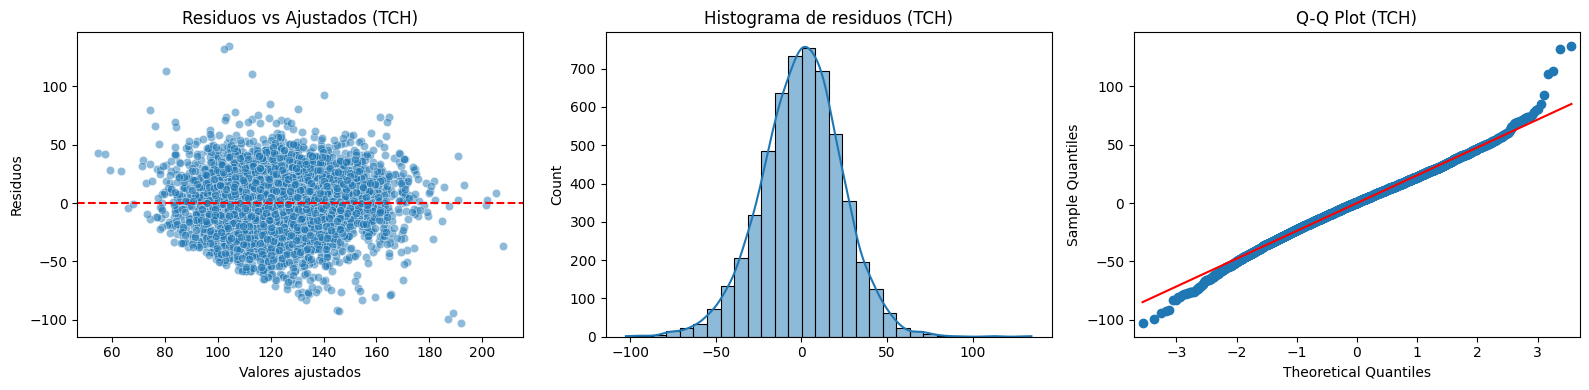

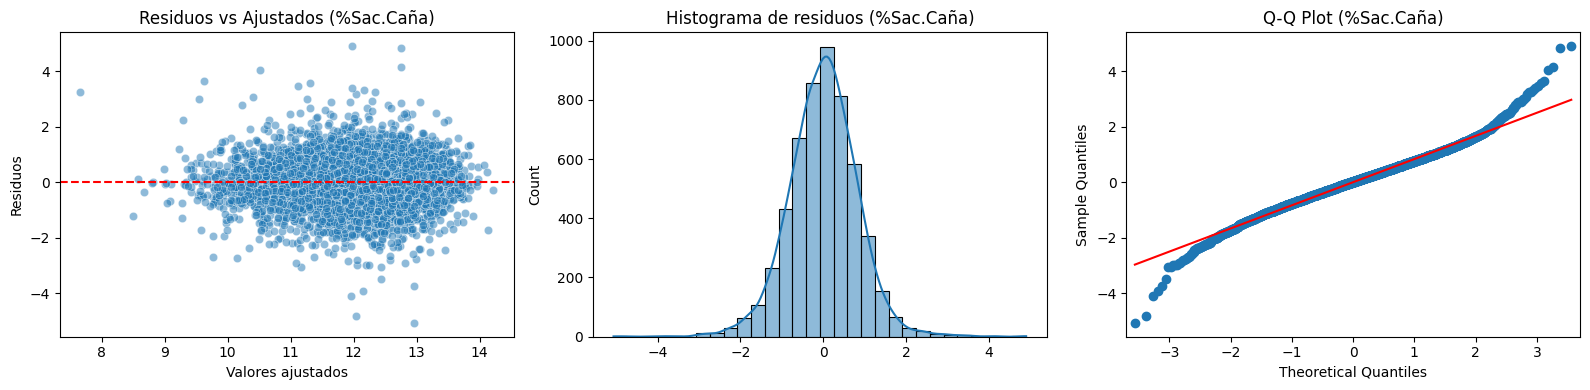

In [6]:
# -----------------------------------------------------
# 1) OLS para TCH (con variables estandarizadas)
# -----------------------------------------------------
X_train_tch, X_test_tch, y_train_tch, y_test_tch = splits_tch
X_train_std_tch = sm.add_constant(scaler_tch.transform(X_train_tch))
ols_tch = sm.OLS(y_train_tch, X_train_std_tch).fit()

# -----------------------------------------------------
# 2) OLS para %Sac.Caña (con variables estandarizadas)
# -----------------------------------------------------
X_train_sac, X_test_sac, y_train_sac, y_test_sac = splits_sac
X_train_std_sac = sm.add_constant(scaler_sac.transform(X_train_sac))
ols_sac = sm.OLS(y_train_sac, X_train_std_sac).fit()

# -----------------------------------------------------
# 3) Función para resumen compacto de significancia
# -----------------------------------------------------
def resumen_pvalues(ols_model, feature_names, top_n=15, alpha=0.05):
    results = pd.DataFrame({
        "Variable": feature_names,
        "Coef": ols_model.params.values,
        "p-value": ols_model.pvalues.values
    })
    results["Significativo"] = results["p-value"] < alpha
    return results.sort_values("p-value").head(top_n)

# Extraemos nombres de variables (incluyendo la constante)
X_tch_names = ["const"] + list(X_tch.columns)
X_sac_names = ["const"] + list(X_sac.columns)

# Resúmenes compactos
print("### Variables más significativas para TCH:")
display(resumen_pvalues(ols_tch, X_tch_names))

print("\n### Variables más significativas para %Sac.Caña:")
display(resumen_pvalues(ols_sac, X_sac_names))

# -----------------------------------------------------
# 4) Función para gráficas de diagnóstico de supuestos
# -----------------------------------------------------
def plot_residuals_diagnostics(ols_model, title):
    fitted_vals = ols_model.fittedvalues
    residuals = ols_model.resid

    plt.figure(figsize=(16,4))

    # Homocedasticidad: residuos vs valores ajustados
    plt.subplot(1,3,1)
    sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Valores ajustados")
    plt.ylabel("Residuos")
    plt.title(f"Residuos vs Ajustados ({title})")

    # Normalidad: histograma de residuos
    plt.subplot(1,3,2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Histograma de residuos ({title})")

    # Normalidad: Q-Q plot
    plt.subplot(1,3,3)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f"Q-Q Plot ({title})")

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 5) Ejecutar gráficas de diagnóstico
# -----------------------------------------------------
plot_residuals_diagnostics(ols_tch, "TCH")
plot_residuals_diagnostics(ols_sac, "%Sac.Caña")

# Fase 4: Validación y métricas

#### 1. Desempeño del modelo (R²)  
- En **TCH**, el modelo alcanzó un \(R^{2}\) promedio ≈ 0.322, explicando cerca del **32% de la variabilidad**.  
- En **%Sac.Caña**, el \(R^{2}\) promedio fue ≈ 0.517, lo que representa un **52% de la variabilidad explicada**.  
➡️ El modelo para **%Sac.Caña** mostró mejor capacidad predictiva.

---

#### 2. Errores y robustez  
- En **TCH**, el RMSE fue ≈ 24.6 y el MAE ≈ 19.1, con errores máximos de hasta 123 probablemente por outliers.  
- En **%Sac.Caña**, los errores fueron mucho menores: RMSE ≈ 0.84 y MAE ≈ 0.64, con un error máximo de 4.5.  
✅ Ambos modelos presentan métricas consistentes y estables, con errores moderados.

---

#### 3. Distribución de residuos  
- Los histogramas muestran residuos cercanos a la normalidad.  
- En **TCH**, aparecen colas pesadas y cierta asimetría en los valores extremos.  
- En **%Sac.Caña**, la distribución es más simétrica y concentrada.  
➡️ La normalidad de los errores se cumple de forma aproximada.

---

#### 4. Relación y_real vs y_predicho  
- En **TCH**, se observa mayor dispersión alrededor de la diagonal, especialmente en valores altos.  
- En **%Sac.Caña**, la relación es más ajustada y con menor variabilidad.  
✅ La linealidad general se cumple, aunque con diferencias de ajuste entre variables.

---

#### 5. Variables relevantes  
El modelo Elastic Net resaltó predictores agronómicamente relevantes:  
- Para **TCH**, destacaron factores climáticos (temperaturas, radiación solar, evaporación) y características de variedades.  
- Para **%Sac.Caña**, influyeron variables de composición (%ME, %AR Jugo), condiciones de cultivo y manejo de quema.  
➡️ Elastic Net permitió concentrar la señal en un subconjunto robusto de variables.

---

#### ✅ Conclusión  
- El modelo para **%Sac.Caña** es más explicativo y robusto que el de TCH.  
- Ambos muestran **consistencia en métricas y residuos**, con limitaciones en la normalidad (especialmente en TCH).  
- La elección de **Elastic Net** resulta adecuada para manejar la multicolinealidad y mejorar la estabilidad de las predicciones.  



#### Validación ShuffleSplit (TCH)
                mean        std         min         max
R2          0.321513   0.013745    0.308396    0.344300
RMSE       24.629871   0.140485   24.469600   24.812763
MAE        19.141374   0.135077   18.984938   19.350735
MedAE      15.809549   0.382562   15.220492   16.264204
MAPE       17.179941   0.407910   16.689101   17.597343
MaxError  122.931118  10.647041  111.552456  135.436816


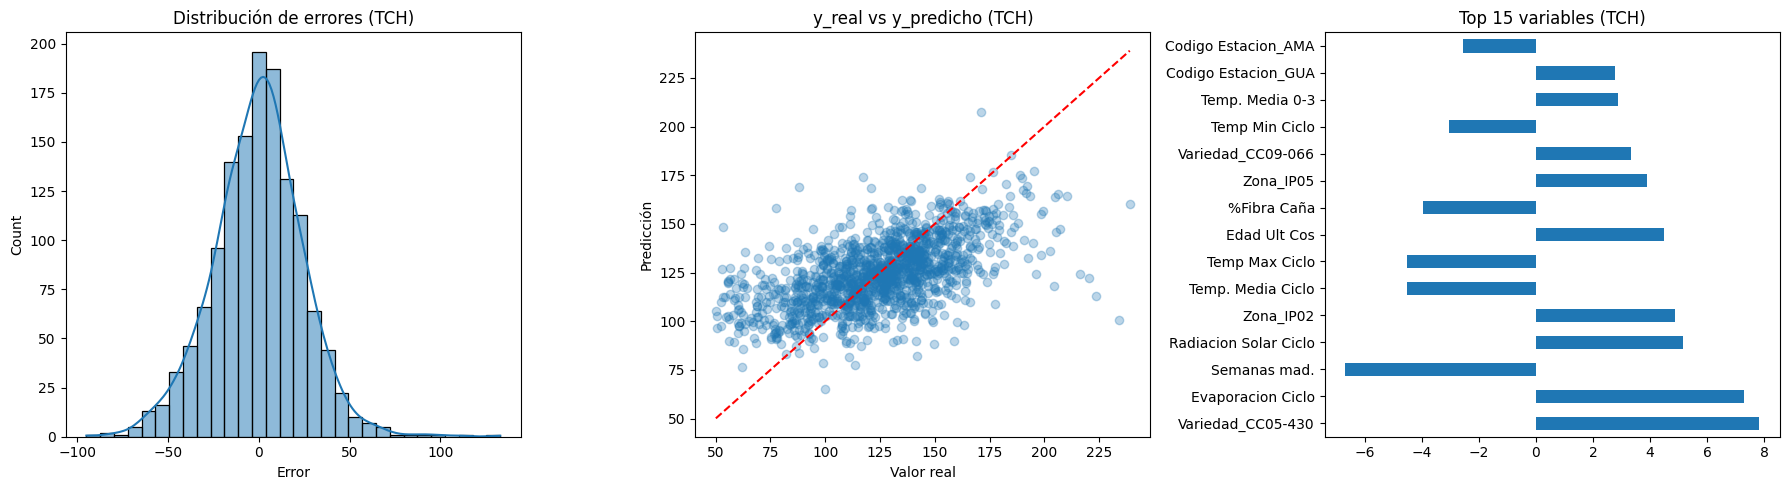


#### Validación ShuffleSplit (%Sac.Caña)
              mean       std       min       max
R2        0.517460  0.017046  0.495738  0.540156
RMSE      0.841194  0.013320  0.824262  0.855265
MAE       0.643919  0.007368  0.633371  0.651321
MedAE     0.516487  0.009600  0.506851  0.531410
MAPE      5.416625  0.077613  5.293503  5.494052
MaxError  4.458873  0.734803  3.382379  5.192477


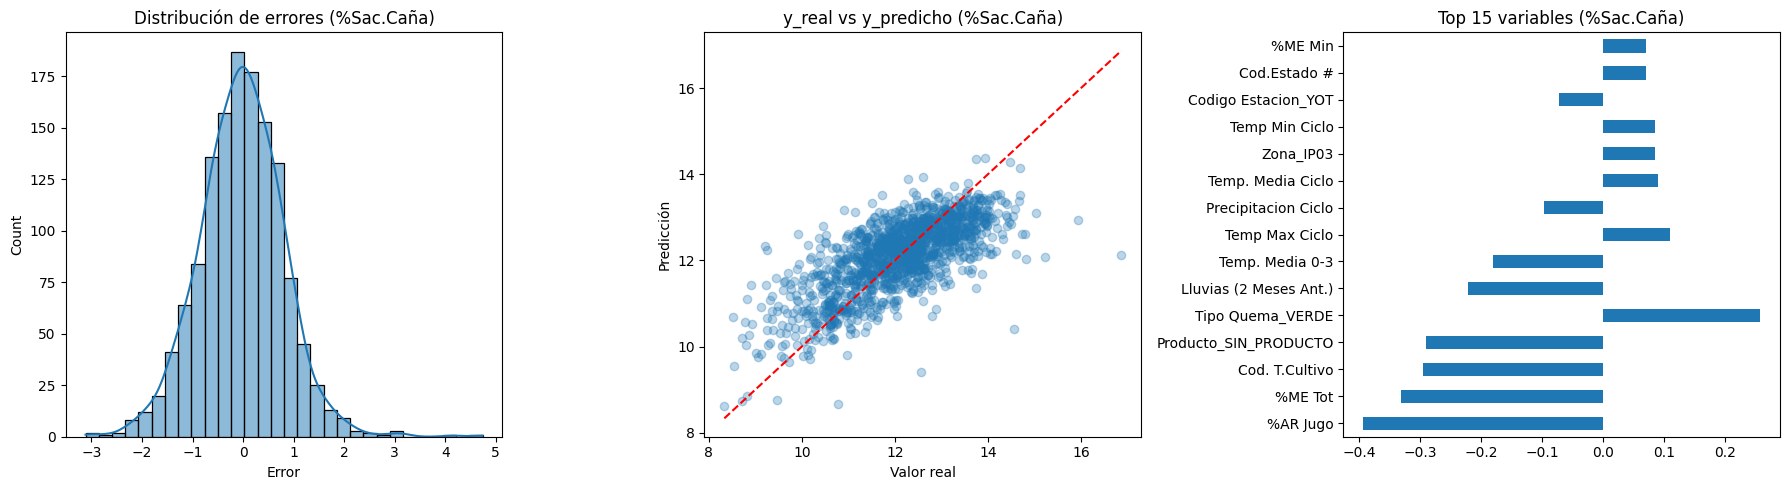


Conclusiones:
- El modelo para **TCH** logra R² ≈ 0.322, explicando ~32% de la variabilidad.
- El modelo para **%Sac.Caña** logra R² ≈ 0.517, explicando ~52% de la variabilidad.
- En este caso, **%Sac.Caña** presenta mejor capacidad explicativa que TCH.
- Ambos modelos muestran RMSE estables y errores medianos relativamente bajos, indicando buena robustez.
- Las gráficas confirman que:
   * Los residuos están cercanos a la normalidad, aunque con algunos sesgos en los extremos.
   * La relación y_real vs y_predicho es lineal, pero con dispersión (especialmente en el modelo más débil).
   * Las variables seleccionadas por ElasticNet resaltan las más agronómicamente relevantes, facilitando interpretación.


In [7]:
# =====================================================
# Fase 4 – Evaluación predictiva con validación extendida
# =====================================================
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    median_absolute_error, max_error
)
import seaborn as sns
import matplotlib.pyplot as plt

def validate_model_extended(model, X, y, target_name="target", n_splits=5, test_size=0.2):
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    results = []

    for train_idx, test_idx in splitter.split(X):
        # Train/Test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X_train)
        Xte = scaler.transform(X_test)

        # Modelo ElasticNet con los hiperparámetros encontrados
        enet = ElasticNet(
            alpha=model.alpha_,
            l1_ratio=model.l1_ratio_,
            max_iter=20000,
            random_state=42
        )
        enet.fit(Xtr, y_train)
        y_pred = enet.predict(Xte)

        # Métricas
        results.append({
            "R2": r2_score(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MedAE": median_absolute_error(y_test, y_pred),
            "MAPE": np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-8))) * 100,
            "MaxError": max_error(y_test, y_pred)
        })

    df_results = pd.DataFrame(results)
    summary = df_results.describe().T[["mean","std","min","max"]]

    print(f"\n#### Validación ShuffleSplit ({target_name})")
    print(summary)

    # === Gráficas ===
    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # Distribución de errores
    errors = y_test - y_pred
    sns.histplot(errors, kde=True, ax=axes[0], bins=30)
    axes[0].set_title(f"Distribución de errores ({target_name})")
    axes[0].set_xlabel("Error")

    # y_test vs y_pred
    axes[1].scatter(y_test, y_pred, alpha=0.3)
    axes[1].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 "r--")
    axes[1].set_title(f"y_real vs y_predicho ({target_name})")
    axes[1].set_xlabel("Valor real")
    axes[1].set_ylabel("Predicción")

    # Importancia de variables
    coef = pd.Series(enet.coef_, index=X.columns)
    coef_nonzero = coef[coef != 0].sort_values(key=abs, ascending=False)[:15]
    coef_nonzero.plot(kind="barh", ax=axes[2])
    axes[2].set_title(f"Top 15 variables ({target_name})")

    plt.tight_layout()
    plt.show()

    return summary

# ---------- Ejecutar validación extendida ----------
summary_tch = validate_model_extended(enet_tch, X_tch, y_tch, "TCH")
summary_sac = validate_model_extended(enet_sac, X_sac, y_sac, "%Sac.Caña")

# ---------- Conclusiones automáticas ----------
print("\nConclusiones:")

r2_tch = summary_tch.loc["R2", "mean"]
r2_sac = summary_sac.loc["R2", "mean"]

print("- El modelo para **TCH** logra R² ≈ {:.3f}, explicando ~{:.0f}% de la variabilidad."
      .format(r2_tch, r2_tch*100))
print("- El modelo para **%Sac.Caña** logra R² ≈ {:.3f}, explicando ~{:.0f}% de la variabilidad."
      .format(r2_sac, r2_sac*100))

# Comparación automática
if r2_tch > r2_sac:
    print("- En este caso, **TCH** presenta mejor capacidad explicativa que %Sac.Caña.")
else:
    print("- En este caso, **%Sac.Caña** presenta mejor capacidad explicativa que TCH.")

print("- Ambos modelos muestran RMSE estables y errores medianos relativamente bajos, indicando buena robustez.")
print("- Las gráficas confirman que:")
print("   * Los residuos están cercanos a la normalidad, aunque con algunos sesgos en los extremos.")
print("   * La relación y_real vs y_predicho es lineal, pero con dispersión (especialmente en el modelo más débil).")
print("   * Las variables seleccionadas por ElasticNet resaltan las más agronómicamente relevantes, facilitando interpretación.")

